#### Проведём анализ данных по фильмам, data set можно скачать по ссылке https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

Для начала подготовим данные:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval


df = pd.read_csv('movies_ds/movies_metadata.csv')
df = df[(df['original_language']=='en') & (df["vote_count"]>=100)]
columns = ["genres", "id","revenue","title","vote_average", "vote_count", "release_date"]

movies = df.loc[:, columns]

# Приводим к типу int для последующего соединения с credits.csv
movies = movies[movies['id'].apply(lambda x: x.isdigit())]
movies['id'] = movies['id'].astype('int')

cast_n_crew = pd.read_csv('movies_ds/credits.csv')

# Приводим к типу int для последующего соединения с movies_metadata.csv
cast_n_crew['id'] = cast_n_crew['id'].astype('int')

# Соединяем две таблицы из movies_metadata.csv и credits.csv
movies = movies.merge(cast_n_crew, on='id')

# Парсинг жанров, каста в список:
def parse_to_name_list(st):
    dcts =  literal_eval(st)
    return [dct['name'] for dct in dcts]

    
movies['genres'] = movies['genres'].apply(parse_to_name_list)
movies['cast'] = movies['cast'].apply(parse_to_name_list)

movies.head()

C:\Users\Ivan\AppData\Local\Temp\ipykernel_6044\2136024866.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_ds/movies_metadata.csv')


,genres,id,revenue,title,vote_average,vote_count,release_date,cast,crew
0,"[Animation, Comedy, Family]",862,373554033.0,Toy Story,7.7,5415.0,1995-10-30,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,"[Adventure, Fantasy, Family]",8844,262797249.0,Jumanji,6.9,2413.0,1995-12-15,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,[Comedy],11862,76578911.0,Father of the Bride Part II,5.7,173.0,1995-02-10,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
3,"[Action, Crime, Drama, Thriller]",949,187436818.0,Heat,7.7,1886.0,1995-12-15,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
4,"[Comedy, Romance]",11860,0.0,Sabrina,6.2,141.0,1995-12-15,"[Harrison Ford, Julia Ormond, Greg Kinnear, An...","[{'credit_id': '52fe44959251416c75039da9', 'de..."


Теперь найдём и визуализируем:
1. 10 актёров с самым высоким средним рейтингом фильмов, в которых они снимались
2. 10 актёров, которые снимались в самых прибыльных фильмах(сравниваем общую сумму кассовых сборов фильмов, в которых они снимались)

<Axes: title={'center': 'TOP 10 ACTORS BY FILM REVENUE'}, xlabel='Dollars', ylabel='actor'>

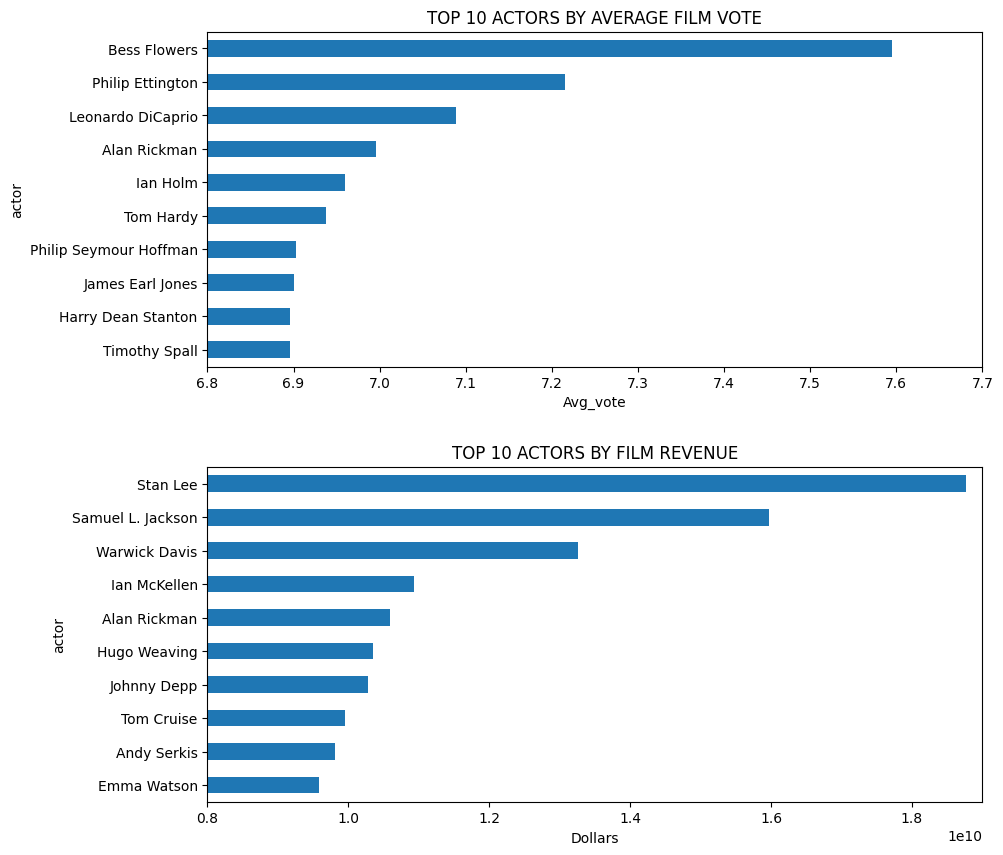

In [3]:
# отсеим мультфильмы:
films = movies[movies['genres'].apply(lambda x: 'Animation' not in x)]

# Разделим список актёров, чтобы на одну строку был один актёр
movies_actors = films.explode('cast')
movies_actors['actor'] = movies_actors.pop('cast')

# Найдём топ10 актёров с самым высоким средним рейтингом фильмов, в которых они снимались
rates = movies_actors.groupby('actor')['vote_average'].agg([('average_vote', 'mean'), ('films_number', 'size')])
rates = rates[rates['films_number'] >= 20]
top10_by_vote = rates['average_vote'].sort_values()[-10:]

# Найдём топ10 актёров "чьи фильмы заработали больше всего"
movies_actors = movies_actors[movies_actors['revenue'] != 0]
top10_by_revenue = movies_actors.groupby('actor')['revenue'].sum().sort_values()[-10:]

# Отобразим оба графика
fig, axes = plt.subplots(2, 1, figsize=(10,10))
fig.subplots_adjust(hspace=0.3)

top10_by_vote.plot(ax=axes[0], kind='barh', title='TOP 10 ACTORS BY AVERAGE FILM VOTE', 
                   xlim=(6.8, 7.7), xlabel='Avg_vote', xticks = np.linspace(6.8, 7.7, 10))
top10_by_revenue.plot(ax=axes[1], kind='barh', title='TOP 10 ACTORS BY FILM REVENUE', xlim=(8*1e9, 19*1e9), xlabel='Dollars')

In [ ]:
Теперь исследуем как менялась популярность выпускаемых жанров в зависимости от года:

array([<Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>], dtype=object)

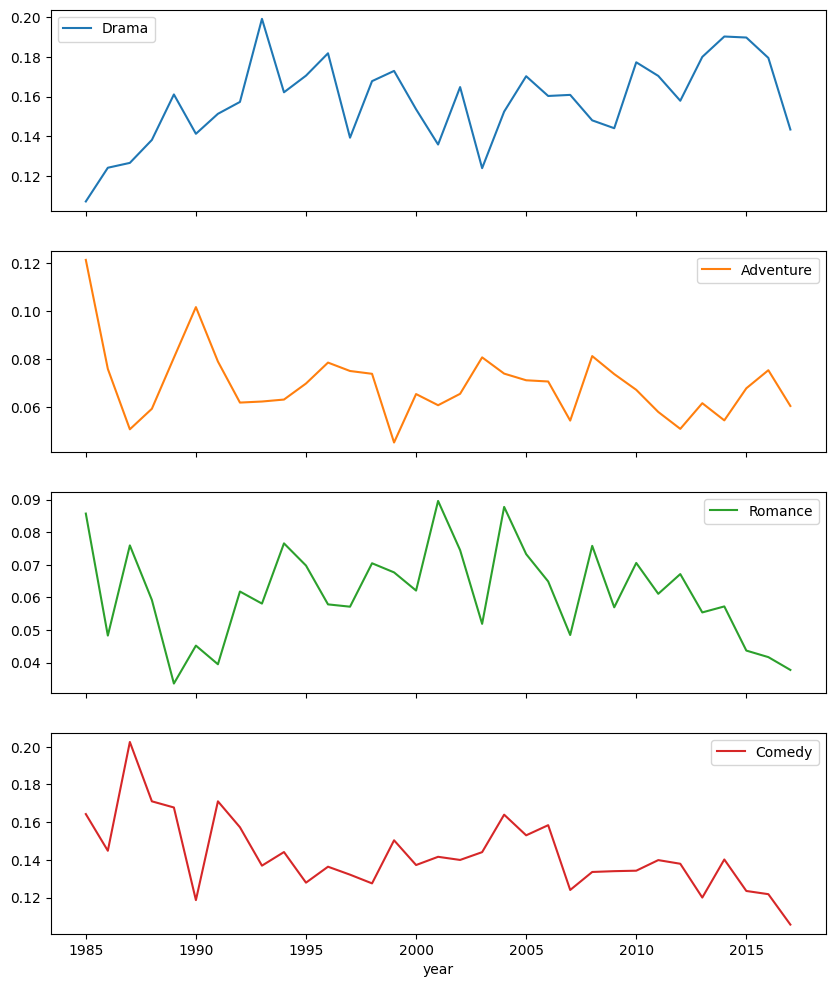

In [39]:
# Приведём строку с датой выпуска к типу datetime и оставим только год
movies['year'] = pd.to_datetime(movies['release_date']).map(lambda x: x.year)

# Оставим только нужные колонки и разобьём список жанров на строки
genres_years = movies[['genres', 'year']].explode('genres')

genres_per_year = pd.crosstab(genres_years['year'], genres_years['genres'])

genres_per_year = genres_per_year.loc[1985:]

# Нормализуем на сумму фильмов за год
genres_per_year = genres_per_year.div(genres_per_year.sum(axis='columns'), axis='index')

# Визуализируем временные ряды для Drama, Adventure, Romance, Comedy
genres_per_year[['Drama', 'Adventure', 'Romance', 'Comedy']].plot(subplots=True, figsize=(10,12))

Вывод: на графиках прослеживается тенденция на снижение выпускаемых фильмов в жанре Adventure, Romance, Comedy
и увеличение количества выпускаемых фильмов в жанре Drama